# Gender bias in Bioinformatics

This notebook shows a series of analyses conducted to study gender bians in bioinformatics. By talking the case of studies of the five most important journals in the area (nucleids acid research, bmc genomics, bmc bioinformatics, oxford bioinformatics, plos computational biology) we analyze bias in the autorship of the papers.

In [1]:
%matplotlib inline

# Import libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import ttest_ind, pearsonr, mannwhitneyu

os.chdir('..')

from db_manager import DBManager

plt.style.use('seaborn')

In [2]:
# Save current dir in case it can be useful later
project_dir = os.getcwd()

# Data load

In [215]:
# Load papers dataset
papers = pd.read_csv(project_dir + '/data/papers.csv')

In [4]:
# Load authors dataset
authors = pd.read_csv(project_dir + '/data/authors.csv')

In [5]:
# Load the dataset containing the cartesian product between papers and authors
papers_authors = pd.read_csv(project_dir + '/data/papers_authors.csv')

In [216]:
print("Raw data:\n-", papers.shape[0], " Papers\n-", authors.shape[0], "Authors\n-", papers_authors.shape[0], 
      "Paper x Authors")

Raw data:
- 46832  Papers
- 116255 Authors
- 220318 Paper x Authors


# Data preprocessing

In [7]:
# Convert vague gender name to specific name
authors.loc[authors['gender']=='mostly_male','gender'] = 'male'
authors.loc[authors['gender']=='mostly_female', 'gender'] = 'female'
papers_authors.loc[papers_authors['author_gender']=='mostly_male','author_gender'] = 'male'
papers_authors.loc[papers_authors['author_gender']=='mostly_female', 'author_gender'] = 'female'

## Remove papers without authors

In [217]:
papers_without_authors = papers[(papers['authors']==0)|(pd.isna(papers['authors']))]
print("Papers without authors " + str(papers_without_authors.shape[0]) + " (most of these are papers " \
      "whose authors have an unidentified gender)")

Papers without authors 1382 (most of these are papers whose authors have an unidentified gender)


In [218]:
papers = papers[(papers['authors']!=0)&(pd.notnull(papers['authors']))]
print("Papers with authors " + str(papers.shape[0]))

Papers with authors 45450


In [10]:
# Remove from the "papers authors" dataset papers without author
papers_authors = papers_authors[~papers_authors['id'].isin(papers_without_authors['id'])]
papers_authors.shape[0]

261614

## Remove authors with unidentified gender

In [11]:
print("There are " + str(authors[(authors['gender']!='male')&(authors['gender']!='female')].shape[0]) +
      " authors with unidentified gender")

There are 27705 authors with unidentified gender


### Filter out authors with unidentified gender

In [12]:
authors = authors[(authors['gender']=='male')|(authors['gender']=='female')]
authors.shape[0]

116255

In [13]:
# Remove rows that have author with unidentified gender
papers_authors = papers_authors[(papers_authors['author_gender']=='male')|
                                (papers_authors['author_gender']=='female')]
papers_authors.shape[0]

220318

## Check data consistency

In [219]:
# Number of rows in dataframe papers must be equal to the number of rows in dataframe 
# papers_authors after grouping it by id
pa_to_check = papers_authors.groupby('id', sort=False, as_index=False)
print("Number of rows are the same: ", pa_to_check.ngroups == papers.shape[0])

Number of rows are the same:  True


In [15]:
# Number of rows in dataframe authors must be equal to the number of rows in dataframe
# papers_authors after grouping it by author id
pa_to_check = papers_authors.groupby('author_id', sort=False, as_index=False)
print("Number of rows are the same: ", pa_to_check.ngroups == authors.shape[0])

Number of rows are the same:  True


In [220]:
dup_papers = papers[papers.duplicated(['id'])]
print("Do not exist duplicated papers: ", dup_papers.shape[0]==0)

Do not exist duplicated papers:  True


In [17]:
dup_authors = authors[authors.duplicated(['id'])]
print("Do not exist duplicated authors: ", dup_authors.shape[0]==0)

Do not exist duplicated authors:  True


# Papers

In [221]:
print("Total papers: " + str(papers.shape[0]))

Total papers: 45450


## Data structure

In [19]:
papers.head()

,id,title,DOI,year,source,citations,edamCategory,link,authors,gender_last_author
0,2-s2.0-85039860463,Improved high-dimensional prediction with Rand...,10.1186/s12859-017-1993-1,2017,Bmc Bioinformatics,2.0,NaN,https://bmcbioinformatics.biomedcentral.com/ar...,5,male
1,2-s2.0-85039845147,Deep convolutional neural networks for pan-spe...,10.1186/s12859-017-1997-x,2017,Bmc Bioinformatics,11.0,NaN,https://bmcbioinformatics.biomedcentral.com/ar...,1,male
2,2-s2.0-85039843898,A comparison of genotyping-by-sequencing analy...,10.1186/s12859-017-2000-6,2017,Bmc Bioinformatics,5.0,NaN,https://bmcbioinformatics.biomedcentral.com/ar...,5,male
3,2-s2.0-85039761019,Incorporating biological prior knowledge for B...,10.1186/s12859-017-1893-4,2017,Bmc Bioinformatics,15.0,NaN,https://bmcbioinformatics.biomedcentral.com/ar...,3,male
4,2-s2.0-85039757640,Deep learning architectures for multi-label cl...,10.1186/s12859-017-1898-z,2017,Bmc Bioinformatics,7.0,NaN,https://bmcbioinformatics.biomedcentral.com/ar...,2,male


## Evolution of papers by year

In [20]:
papers_by_year = papers.groupby(['year', 'source']).size()

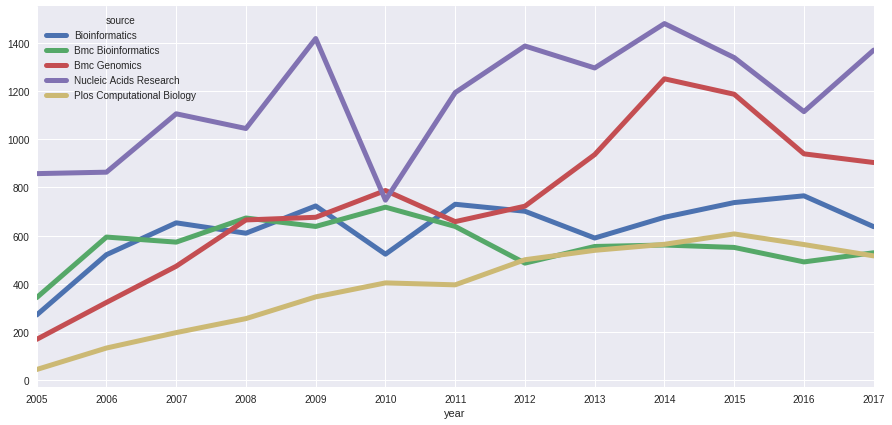

In [21]:
fig, ax = plt.subplots(figsize=(15,7))
papers_by_year.unstack().plot(ax=ax, lw=5)
ax.set_xticks(range(2005,2018))

## Evolution of average citations over years

In [22]:
papers['citations'].describe()

count    44775.000000
mean        48.028967
std        222.930204
min          1.000000
25%          9.000000
50%         19.000000
75%         40.000000
max      17237.000000
Name: citations, dtype: float64

### Paper with max citation

In [23]:
papers[papers['citations']==max(papers['citations'])].head()

,id,title,DOI,year,source,citations,edamCategory,link,authors,gender_last_author
40253,2-s2.0-36448991500,Clustal W and Clustal X version 2.0,10.1093/bioinformatics/btm404,2007,Bioinformatics,17237.0,Computational Biology > Molecular genetics,https://academic.oup.com/bioinformatics/articl...,11,male


### Average citations over years

In [24]:
avg_citations_by_year = papers.groupby('year').mean()['citations']

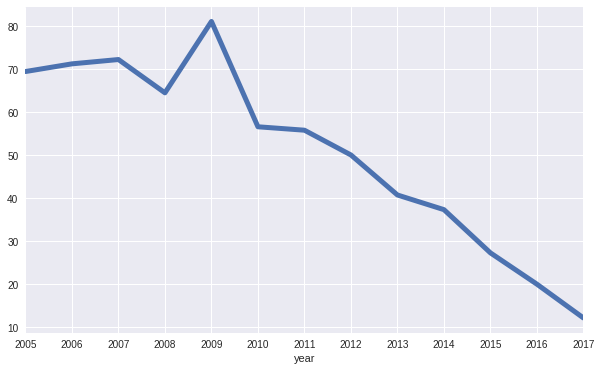

In [25]:
fig, ax = plt.subplots(figsize=(10,6))
avg_citations_by_year.plot(lw=5)
ax.set_xticks(range(2005,2018))

## Average authors over years

In [26]:
papers['authors'].describe()

count    45450.000000
mean         4.847481
std          4.132997
min          1.000000
25%          3.000000
50%          4.000000
75%          6.000000
max        223.000000
Name: authors, dtype: float64

### Paper with max number of authors

In [27]:
papers[papers['authors']==max(papers['authors'])].head()

,id,title,DOI,year,source,citations,edamCategory,link,authors,gender_last_author
20120,2-s2.0-84976902208,The SIB Swiss Institute of bioinformatics' res...,10.1093/nar/gkv1310,2016,Nucleic Acids Research,16.0,NaN,https://academic.oup.com/nar/article/44/D1/D27...,223,female


### Average number of authors over years

In [28]:
avg_authors_by_year = papers.groupby('year').mean()['authors']

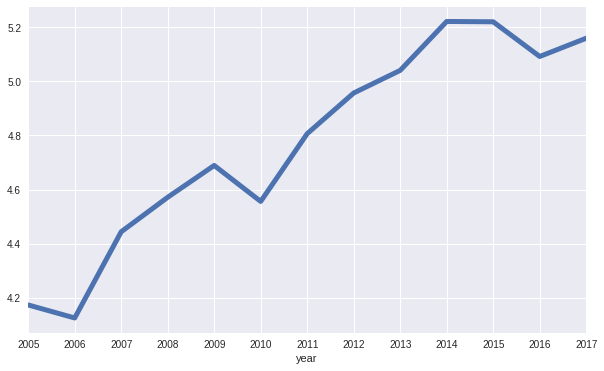

In [29]:
fig, ax = plt.subplots(figsize=(10,6))
avg_authors_by_year.plot(lw=5)
ax.set_xticks(range(2005,2018))

## Categories

In [30]:
row_categories = papers[pd.notnull(papers['edamCategory'])]['edamCategory']
categories = []
for row_category in row_categories:
    for category in row_category.split('>'):
        clean_category = category.strip()
        exists_category_dict = False
        for category_dict in categories:
            if category_dict['category_name'] == clean_category:
                category_dict['count'] += 1
                exists_category_dict = True
                break
        if not exists_category_dict:
            categories.append(
                {
                    'category_name': clean_category,
                    'count': 1
                }
            )

In [31]:
categories_df = pd.DataFrame(categories)
total_categories = categories_df.shape[0]
print("There are " + str(total_categories) + " categories")
categories_df.sort_values('count', inplace=True, ascending=False)
categories_df.head()

There are 18 categories


,category_name,count
0,Computational Biology,23245
2,Omics,12057
3,Genomics,12057
6,Nucleic acids,6350
5,Functional genomics,5076


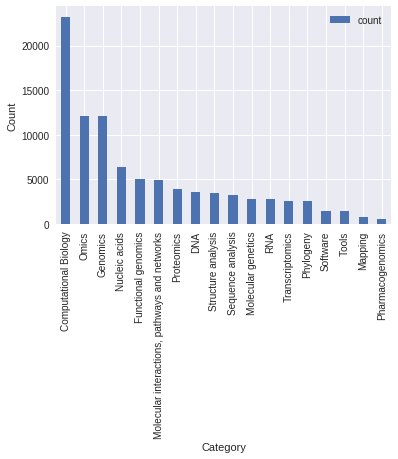

In [32]:
categories_df.plot.bar(x='category_name', y='count')
plt.xticks(rotation=90)
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()

## Source

In [33]:
papers_by_source = papers.groupby('source').size().sort_values(ascending=False)

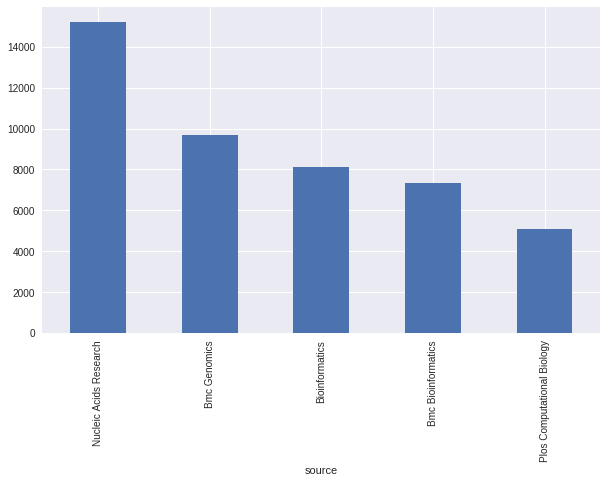

In [34]:
plt.figure(figsize=(10,6))
papers_by_source.plot(kind='bar')

# Authors

In [35]:
print("Total authors: " + str(authors.shape[0]))

Total authors: 116255


## Data structure

In [36]:
authors.head()

,id,name,gender,papers,total_citations,papers_as_first_author,papers_as_last_author,papers_with_citations
0,57193540655,Dennis E Te Beest,male,1,2.0,1,0,1
1,56135856400,Steven W Mes,male,1,2.0,0,0,1
2,8205265800,Saskia M Wilting,female,4,171.0,0,0,4
3,7005976355,Ruud H Brakenhoff,male,4,49.0,0,0,4
4,6701725064,Mark A van de Wiel,male,17,291.0,3,8,16


## Gender distribution 

In [37]:
authors_by_gender = authors.groupby('gender').size().sort_values(ascending=False)
per_authors_by_gender = authors_by_gender/authors.shape[0]
per_authors_by_gender

gender
male      0.647439
female    0.352561
dtype: float64

In [38]:
authors_by_gender

gender
male      75268
female    40987
dtype: int64

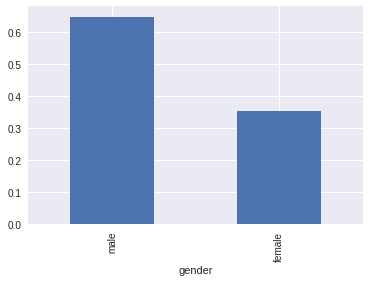

In [39]:
per_authors_by_gender.plot.bar()

## Papers

### Citations per paper

In [40]:
authors['total_citations'].describe()

count    115368.000000
mean        115.877973
std         554.802546
min           1.000000
25%          12.000000
50%          28.000000
75%          70.000000
max       39587.000000
Name: total_citations, dtype: float64

### Author with max number of citations

In [41]:
authors[authors['total_citations']==max(authors['total_citations'])]

,id,name,gender,papers,total_citations,papers_as_first_author,papers_as_last_author,papers_with_citations
67758,7102868950,Richard Durbin,male,23,39587.0,1,12,23


### Top-10 Most cited authors

In [57]:
authors.sort_values('total_citations', inplace=True, ascending=False)
mca = authors[['name','gender', 'papers', 'total_citations']].copy()
mca['citations_by_papers'] = mca['total_citations']/mca['papers']
mca.head(10)

,name,gender,papers,total_citations,citations_by_papers
67758,Richard Durbin,male,23,39587.0,1721.173913
86371,Hamish McWilliam,male,24,27544.0,1147.666667
23639,Peer Bork,male,66,25941.0,393.045455
10253,Rodrigo Lopez,male,21,22756.0,1083.619048
3968,Alexandros Stamatakis,male,22,20689.0,940.409091
106327,Franck Valentin,male,8,20104.0,2513.000000
4931,Gonçalo R Abecasis,male,17,19713.0,1159.588235
8485,Alex Bateman,male,38,19267.0,507.026316
17008,Toby J Gibson,male,16,18810.0,1175.625000
5885,Gordon K Smyth,male,27,18642.0,690.444444


#### Top-10 most cited female authors

In [58]:
authors.sort_values('total_citations', inplace=True, ascending=False)
mcfa = authors[authors['gender']=='female'][['name','gender', 'papers', 'total_citations']].copy()
mcfa['citations_by_papers'] = mcfa['total_citations']/mcfa['papers']
mcfa.head(10)

,name,gender,papers,total_citations,citations_by_papers
34138,Jue Ruan,female,9,15558.0,1728.666667
7703,Cathy H Wu,female,39,12781.0,327.717949
75349,Catherine Rivoire,female,19,11958.0,629.368421
75344,Claire O'Donovan,female,21,10952.0,521.523810
75334,Ursula Hinz,female,16,10944.0,684.000000
20880,Jaina Mistry,female,10,10763.0,1076.300000
10242,Lydie Bougueleret,female,26,10740.0,413.076923
3398,Tatiana Tatusova,female,30,10245.0,341.500000
75323,Elisabeth Coudert,female,20,10076.0,503.800000
62289,Donna R Maglott,female,22,9961.0,452.772727


### Papers per author

In [59]:
authors['papers'].describe()

count    116255.000000
mean          1.897235
std           2.407637
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          73.000000
Name: papers, dtype: float64

### Top-10 Most productive authors

In [60]:
authors.sort_values('papers', inplace=True, ascending=False)
authors[['name','gender','papers']].head(10)

,name,gender,papers
12665,Mark B Gerstein,male,73
553,Peter F Stadler,male,73
5460,Janusz M Bujnicki,male,71
23639,Peer Bork,male,66
781,Joaquín Dopazo,male,65
9126,Alfonso Valencia,male,64
12069,William Stafford Noble,male,52
4148,Philip E Bourne,male,52
2682,Rolf Backofen,male,51
10631,David S Wishart,male,49


#### Top-10 most productive female authors

In [61]:
authors.sort_values('papers', inplace=True, ascending=False)
authors[authors['gender']=='female'][['name','gender','papers']].head(10)

,name,gender,papers
9894,Rita Casadio,female,47
10411,Christine A Orengo,female,46
16790,Olga G Troyanskaya,female,40
7703,Cathy H Wu,female,39
7009,Judith A Blake,female,38
1864,Luonan Chen,female,38
109,Shoba Ranganathan,female,37
13660,Ruth Nussinov,female,36
6106,Sophia Ananiadou,female,35
16080,Charlotte M Deane,female,33


### Papers as first author

In [62]:
authors['papers_as_first_author'].describe()

count    116255.000000
mean          0.327160
std           0.680183
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          12.000000
Name: papers_as_first_author, dtype: float64

### Top-10 authors that appeared as first author

In [63]:
authors.sort_values('papers_as_first_author', inplace=True, ascending=False)
authors[['name','gender','papers','papers_as_first_author']].head(10)

,name,gender,papers,papers_as_first_author
11461,Shuangge Ma,female,17,12
135,Jonathan D Wren,male,29,11
182,Robert Hoehndorf,male,18,11
5044,Michiaki Hamada,male,23,11
13305,Emidio Capriotti,male,20,11
12167,Andrey Ptitsyn,male,11,11
133531,Christiana N Fogg,female,10,10
75555,Dennis A Benson,male,20,10
8177,Richard Tzong-Han Tsai,male,13,10
12749,Stephen Winters-Hilt,male,18,10


#### Top-10 female authors that appeared as first author

In [64]:
authors.sort_values('papers_as_first_author', inplace=True, ascending=False)
authors[authors['gender']=='female'][['name','gender','papers','papers_as_first_author']].head(10)

,name,gender,papers,papers_as_first_author
11461,Shuangge Ma,female,17,12
133531,Christiana N Fogg,female,10,10
11943,Christina Backes,female,23,9
56997,Wei-Hua Chen,female,11,8
17432,Yana Bromberg,female,16,8
7009,Judith A Blake,female,38,8
75891,Cristina Aurrecoechea,female,9,7
13129,Michelle S Scott,female,13,7
69694,Xue-Hai Liang,female,16,7
21189,Milana Frenkel-Morgenstern,female,8,7


### Papers as last author

In [65]:
authors['papers_as_last_author'].describe()

count    116255.000000
mean          0.345043
std           1.309024
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          63.000000
Name: papers_as_last_author, dtype: float64

### Top-10 authors that appeared as first author

In [66]:
authors.sort_values('papers_as_last_author', inplace=True, ascending=False)
authors[['name','gender','papers','papers_as_last_author']].head(10)

,name,gender,papers,papers_as_last_author
12665,Mark B Gerstein,male,73,63
23639,Peer Bork,male,66,44
9894,Rita Casadio,female,47,39
5460,Janusz M Bujnicki,male,71,38
12069,William Stafford Noble,male,52,38
8436,Burkhard Rost,male,46,37
9126,Alfonso Valencia,male,64,37
7712,Gajendra Pal Singh Raghava,male,40,35
16790,Olga G Troyanskaya,female,40,35
781,Joaquín Dopazo,male,65,35


#### Top-10 female authors that appeared as first author

In [67]:
authors.sort_values('papers_as_last_author', inplace=True, ascending=False)
authors[authors['gender']=='female'][['name','gender','papers','papers_as_last_author']].head(10)

,name,gender,papers,papers_as_last_author
9894,Rita Casadio,female,47,39
16790,Olga G Troyanskaya,female,40,35
109,Shoba Ranganathan,female,37,31
10411,Christine A Orengo,female,46,27
6106,Sophia Ananiadou,female,35,26
1864,Luonan Chen,female,38,24
16080,Charlotte M Deane,female,33,24
11390,Anna Tramontano,female,33,24
53,Jinn-Moon Yang,female,25,22
6645,Taesung Park,female,32,21


## Papers without citations

In [68]:
authors['papers_without_citations'] = authors['papers'] - authors['papers_with_citations']
authors[['id','name','gender','papers','papers_without_citations']].head()

,id,name,gender,papers,papers_without_citations
12665,24755400900,Mark B Gerstein,male,73,0
23639,7103061421,Peer Bork,male,66,1
9894,7004943169,Rita Casadio,female,47,0
5460,7007165509,Janusz M Bujnicki,male,71,0
12069,7102482003,William Stafford Noble,male,52,1


In [69]:
authors['papers_without_citations'].describe()

count    116255.000000
mean          0.021040
std           0.159365
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          10.000000
Name: papers_without_citations, dtype: float64

# Authorship

## Data structure

In [70]:
papers_authors.head()

,id,title,doi,year,category,author_id,author,author_gender,author_position
0,2-s2.0-85039860463,Improved high-dimensional prediction with Rand...,10.1186/s12859-017-1993-1,2017,NaN,57193540655,Dennis E Te Beest,male,1
1,2-s2.0-85039860463,Improved high-dimensional prediction with Rand...,10.1186/s12859-017-1993-1,2017,NaN,56135856400,Steven W Mes,male,2
2,2-s2.0-85039860463,Improved high-dimensional prediction with Rand...,10.1186/s12859-017-1993-1,2017,NaN,8205265800,Saskia M Wilting,female,3
3,2-s2.0-85039860463,Improved high-dimensional prediction with Rand...,10.1186/s12859-017-1993-1,2017,NaN,7005976355,Ruud H Brakenhoff,male,4
4,2-s2.0-85039860463,Improved high-dimensional prediction with Rand...,10.1186/s12859-017-1993-1,2017,NaN,6701725064,Mark A van de Wiel,male,5


In [72]:
papers_grouped_by_title = papers_authors.drop(['doi', 'year', 'category', 'author', 'author_position'], axis=1).groupby(['id','author_gender'], sort=False, as_index=False)
agg_papers_grouped_df = papers_grouped_by_title[['author_gender']].agg({'author_gender': {'count_gender': 'count'}})
agg_papers_grouped_df.head()

,id,author_gender,count_gender
0,2-s2.0-85039860463,male,1
1,2-s2.0-85039860463,female,1
2,2-s2.0-85039845147,male,2
3,2-s2.0-85039843898,male,1
4,2-s2.0-85039761019,male,1


In [73]:
papers_gender_dist = agg_papers_grouped_df.pivot(columns='author_gender', values='count_gender', index='id')
papers_gender_dist = papers_gender_dist.fillna(0)
papers_gender_dist.head()

author_gender,female,male
id,,
2-s2.0-13244249624,1.0,0.0
2-s2.0-13244251063,1.0,9.0
2-s2.0-13244251064,8.0,1.0
2-s2.0-13244252316,0.0,1.0
2-s2.0-13244255410,6.0,1.0


In [74]:
papers_gender_dist['most_female'] = np.where(papers_gender_dist['female']>papers_gender_dist['male'], 1, 0)
papers_gender_dist['most_male'] = np.where(papers_gender_dist['male']>papers_gender_dist['female'], 1, 0)
papers_gender_dist['equal_gender'] = np.where(papers_gender_dist['male']==papers_gender_dist['female'], 1, 0)
papers_gender_dist['only_male'] = np.where(papers_gender_dist['female']==0, 1, 0)
papers_gender_dist['only_female'] = np.where(papers_gender_dist['male']==0, 1, 0)
papers_gender_dist.head()

author_gender,female,male,most_female,most_male,equal_gender,only_male,only_female
id,,,,,,,
2-s2.0-13244249624,1.0,0.0,1,0,0,0,1
2-s2.0-13244251063,1.0,9.0,0,1,0,0,0
2-s2.0-13244251064,8.0,1.0,1,0,0,0,0
2-s2.0-13244252316,0.0,1.0,0,1,0,1,0
2-s2.0-13244255410,6.0,1.0,1,0,0,0,0


## Papers with mostly male authors

In [75]:
raw_num = papers_gender_dist['most_male'].sum()
per_num = round(raw_num/papers_gender_dist.shape[0]*100,2)
print('There are {}({}%) papers which have mostly male authors'.format(raw_num, per_num))

There are 26926(59.24%) papers which have mostly male authors


## Papers with mostly female authors

In [76]:
raw_num = papers_gender_dist['most_female'].sum()
per_num = round(raw_num/papers_gender_dist.shape[0]*100,2)
print('There are {}({}%) papers which have mostly female authors'.format(raw_num, per_num))

There are 13256(29.17%) papers which have mostly female authors


## Papers with only male authors

In [77]:
raw_num = papers_gender_dist['only_male'].sum()
per_num = round(raw_num/papers_gender_dist.shape[0]*100,2)
print('There are {}({}%) papers which have only male authors'.format(raw_num, per_num))

There are 15583(34.29%) papers which have only male authors


## Papers with only female authors

In [78]:
raw_num = papers_gender_dist['only_female'].sum()
per_num = round(raw_num/papers_gender_dist.shape[0]*100,2)
print('There are {}({}%) papers which have only female authors'.format(raw_num, per_num))

There are 1775(3.91%) papers which have only female authors


## Papers with equal number of male and female authors

In [79]:
raw_num = papers_gender_dist['equal_gender'].sum()
per_num = round(raw_num/papers_gender_dist.shape[0]*100,2)
print('There are {}({}%) papers which have equal number of male and female authors'.format(raw_num, per_num))

There are 5268(11.59%) papers which have equal number of male and female authors


## Distribution of first author gender

The total does not sum up 1 because there are papers in which the first author has unidentified gender.

In [339]:
papers_authors[papers_authors['author_position']==1].author_gender.value_counts()/papers.shape[0]

male      0.578090
female    0.262689
Name: author_gender, dtype: float64

## Number of papers lead by a woman

Only first authors with identified gender (male/female) are considered in the analysis.

In [88]:
raw_num = papers_authors[(papers_authors['author_gender']=='female')&(papers_authors['author_position']==1)].shape[0]
print('There are {} papers which have a woman as the first author'.format(raw_num))

There are 11844 papers which have a woman as the first author


## Number of papers lead by a man

Only first authors with identified gender (male/female) are considered in the analysis.

In [87]:
raw_num = papers_authors[(papers_authors['author_gender']=='male')&(papers_authors['author_position']==1)].shape[0]
print('There are {} papers which have a man as the first author'.format(raw_num))

There are 26137 papers which have a man as the first author


## Evolution of male and female authors by year

In [89]:
papers_grouped_by_year = papers_authors.drop(['id', 'title', 'doi', 'category', 'author', 'author_position'], axis=1).\
    groupby(['year','author_gender'], as_index=False)
agg_papers_grouped_df = papers_grouped_by_year[['author_gender']].agg({'author_gender': {'count_gender': 'count'}})

/home/jorge/python_venvs/gender_identification/lib/python3.6/site-packages/pandas/core/groupby/generic.py:1315: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [92]:
papers_gender_dist_by_year = agg_papers_grouped_df.pivot(columns='author_gender', values='count_gender', 
                                                         index='year')
papers_gender_dist_by_year = papers_gender_dist_by_year.fillna(0)
papers_gender_dist_by_year.head(10)

author_gender,female,male
year,,
2005,1886,5151
2006,2681,7365
2007,3686,9655
2008,4160,10688
2009,4994,12824
2010,4089,10395
2011,5022,12353
2012,5617,13193
2013,5987,13745


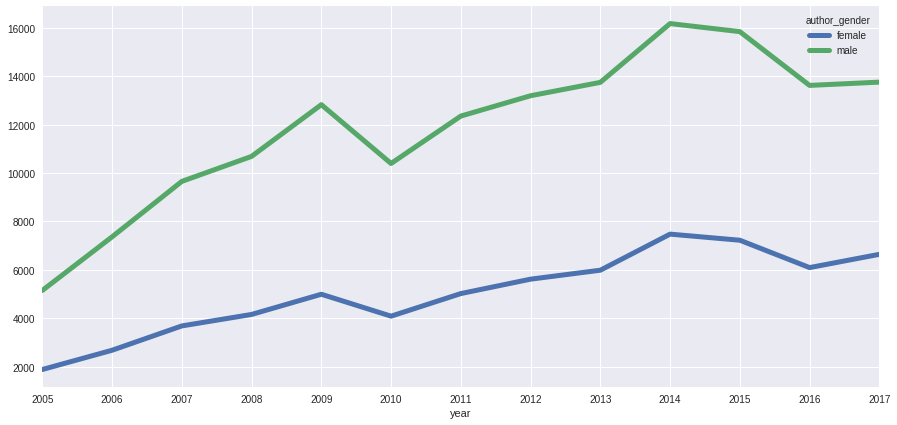

In [96]:
fig, ax = plt.subplots(figsize=(15,7))
papers_gender_dist_by_year.plot(ax=ax, lw=5)
ax.set_xticks(range(2005,2018));

## Position in papers of female authors

In [97]:
# filter out male authors
female_authors = papers_authors[papers_authors['author_gender']=='female']
# drop unneccesary columns
female_authors = female_authors.drop(['id', 'title', 'doi', 'year', 'category', 'author_gender'], axis=1)
# group rows authors by author
female_authors_grouped_by_position = female_authors.groupby(['author','author_position'], as_index=False)
# compute frequency of positions
agg_fa_grouped_df = female_authors_grouped_by_position[['author_position']].\
    agg({'author_position': {'count_position': 'count'}})
# pivot table
female_authors_pos = agg_fa_grouped_df.pivot(columns='author_position', values='count_position', index='author')
# fill na values with zero
female_authors_pos = female_authors_pos.fillna(0)
female_authors_pos.head()

author_position,1,2,3,4,5,6,7,8,9,10,...,495,516,537,558,589,593,622,656,669,672
author,,,,,,,,,,,,,,,,,,,,,
A A Fedorova,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Bendoraite,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A-Lien Lu,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Aafke A van den Berg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Aafke W F Janssen,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [98]:
female_authors_pos['freq_pos'] = female_authors_pos.idxmax(axis=1)  #.value_counts()[:10]

In [99]:
female_authors_pos[female_authors_pos['freq_pos']==1].head(10)

author_position,1,2,3,4,5,6,7,8,9,10,...,516,537,558,589,593,622,656,669,672,freq_pos
author,,,,,,,,,,,,,,,,,,,,,
Aafke A van den Berg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
Aafke W F Janssen,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
Aakrosh Ratan,2.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
Aamira Tariq,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
Aanchal Katoch,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
Aarti Garg,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
Aarti Sevilimedu,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
Abbey B Holt,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
Abha Belorkar,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


### Positions most frequently occuped by female authors in papers

In [100]:
female_authors_pos['freq_pos'].value_counts()[:10]

1     9046
2     7903
3     6498
4     4878
5     3441
6     2464
7     1724
8     1121
9      783
10     526
Name: freq_pos, dtype: int64

In [102]:
title_papers_led_female = papers_authors[(papers_authors['author_gender']=='female') & \
                                         (papers_authors['author_position']==1)]['title']
papers_led_female = papers_authors[papers_authors['title'].isin(title_papers_led_female)]
papers_led_female = papers_led_female.drop(['id', 'doi', 'year', 'category', 'author', 'author_position'], axis=1)
papers_led_female_grouped_by_title = papers_led_female.groupby(['title','author_gender'], \
                                                               sort=False, as_index=False)
agg_papers_grouped_lbf = papers_led_female_grouped_by_title[['author_gender']].\
    agg({'author_gender': {'count_gender': 'count'}})
papers_led_female_df = agg_papers_grouped_lbf.pivot(columns='author_gender', values='count_gender', index='title') 
papers_led_female_df = papers_led_female_df.fillna(0)
num_papers_led_by_woman = papers_led_female_df.shape[0]
per_papers_led_by_woman = round(num_papers_led_by_woman/papers.shape[0]*100,2)
print('There are {} ({}%) papers led by a woman (only first authors with '
      'identified gender as considered in the analysis)'.format(num_papers_led_by_woman, per_papers_led_by_woman))
num_papers_led_by_woman_men = papers_led_female_df[papers_led_female_df['male']>0].shape[0]
per_papers_led_by_woman_men = round(num_papers_led_by_woman_men/num_papers_led_by_woman*100,2)
print('In {} ({}%) of these papers, there are also men as co-authors'.format(num_papers_led_by_woman_men, \
                                                                          per_papers_led_by_woman_men))

There are 11842 (26.06%) papers led by a woman (only first authors with identified gender as considered in the analysis)
In 10878 (91.86%) of these papers, there are also men as co-authors


## Citations by gender

### Citations of papers with mostly female and male authors

In [109]:
papers_with_most_females = papers_gender_dist[papers_gender_dist['most_female']==1].index.values
c_mostly_female_authors = papers[papers['id'].isin(papers_with_most_females)]['citations']
papers_with_most_male = papers_gender_dist[papers_gender_dist['most_male']==1].index.values
c_mostly_male_authors = papers[papers['id'].isin(papers_with_most_male)]['citations']

In [110]:
c_mostly_female_authors.describe()

count    13065.000000
mean        46.277076
std        195.858982
min          1.000000
25%          9.000000
50%         19.000000
75%         39.000000
max      15261.000000
Name: citations, dtype: float64

In [111]:
c_mostly_male_authors.describe()

count    26507.000000
mean        49.838081
std        248.619011
min          1.000000
25%          9.000000
50%         19.000000
75%         40.000000
max      17237.000000
Name: citations, dtype: float64

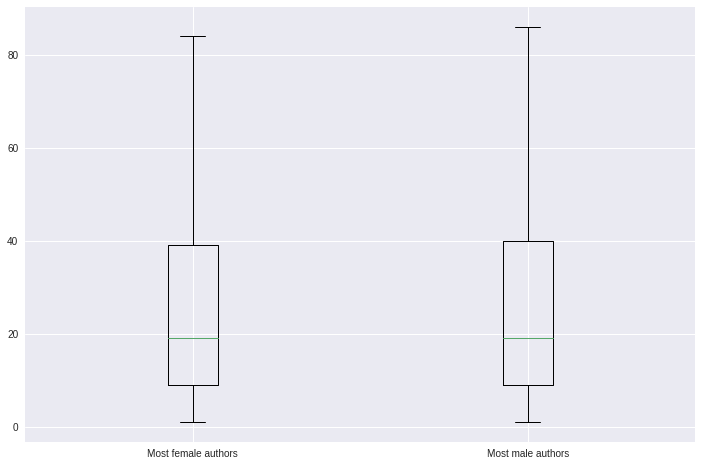

In [147]:
# Remove NaN values to avoid runtime warnings
c_mostly_female_authors = c_mostly_female_authors[c_mostly_female_authors.notnull()]
c_mostly_male_authors = c_mostly_male_authors[c_mostly_male_authors.notnull()]
data_to_plot = [c_mostly_female_authors, c_mostly_male_authors]
# Create a figure instance
fig = plt.figure(1, figsize=(12, 8))
# Create an axes instance
ax = fig.add_subplot(111)
ax.set_xticklabels(['Most female authors', 'Most male authors'])
# Create the boxplot
bp = ax.boxplot(data_to_plot, showfliers=False)

#### Are the different statistically significant?

In [148]:
ttest,pval = ttest_ind(c_mostly_female_authors,c_mostly_male_authors)
if pval < 0.05:
    print("The difference is statistically significant, p-value:",round(pval,3))
else:
    print("The difference is not statistically significant, p-value:",round(pval,3))

The difference is not statistically significant, p-value: 0.152


### Citations of papers with only female and male authors

In [151]:
papers_with_most_females = papers_gender_dist[papers_gender_dist['only_female']==1].index.values
c_only_female_authors = papers[papers['id'].isin(papers_with_most_females)]['citations']
papers_with_most_male = papers_gender_dist[papers_gender_dist['only_male']==1].index.values
c_only_male_authors = papers[papers['id'].isin(papers_with_most_male)]['citations']

In [152]:
c_only_female_authors.describe()

count    1726.000000
mean       33.126883
std        96.723683
min         1.000000
25%         8.000000
50%        15.000000
75%        32.000000
max      2595.000000
Name: citations, dtype: float64

In [153]:
c_only_male_authors.describe()

count    15299.000000
mean        54.224394
std        304.747408
min          1.000000
25%          8.000000
50%         18.000000
75%         41.000000
max      17237.000000
Name: citations, dtype: float64

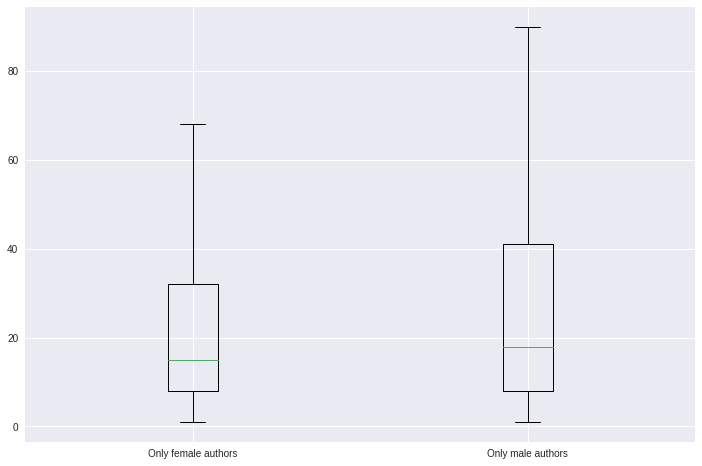

In [154]:
c_only_female_authors = c_only_female_authors[c_only_female_authors.notnull()]
c_only_male_authors = c_only_male_authors[c_only_male_authors.notnull()]
data_to_plot = [c_only_female_authors, c_only_male_authors]
# Create a figure instance
fig = plt.figure(1, figsize=(12, 8))
# Create an axes instance
ax = fig.add_subplot(111)
ax.set_xticklabels(['Only female authors', 'Only male authors'])
# Create the boxplot
bp = ax.boxplot(data_to_plot, showfliers=False)

#### Are the different statistically significant?

In [155]:
ttest,pval = ttest_ind(c_only_female_authors,c_only_male_authors)
if pval < 0.05:
    print("The difference is statistically significant, p-value:",round(pval,3))
else:
    print("The difference is not statistically significant, p-value:",round(pval,3))

The difference is statistically significant, p-value: 0.004


### Citations of papers lead by female and male authors

In [156]:
# citations led by female authors
c_led_female_authors = papers[papers['title'].isin(papers_led_female_df.index.values)]['citations']
# citations led by male authors
title_papers_led_male = papers_authors[(papers_authors['author_gender']=='male') & \
                                       (papers_authors['author_position']==1)]['title']
papers_led_male = papers_authors[papers_authors['title'].isin(title_papers_led_male)]
papers_led_male = papers_led_male.drop(['id', 'doi', 'year', 'category', 'author', 'author_position'], axis=1)
papers_led_male_grouped_by_title = papers_led_male.groupby(['title','author_gender'], sort=False, as_index=False)
agg_papers_grouped_lbm = papers_led_male_grouped_by_title[['author_gender']].\
    agg({'author_gender': {'count_gender': 'count'}})
papers_led_male_df = agg_papers_grouped_lbm.pivot(columns='author_gender', values='count_gender', index='title')
c_led_male_authors = papers[papers['title'].isin(papers_led_male_df.index.values)]['citations']

/home/jorge/python_venvs/gender_identification/lib/python3.6/site-packages/pandas/core/groupby/generic.py:1315: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [157]:
c_led_female_authors.describe()

count    11713.000000
mean        38.637582
std        102.364058
min          1.000000
25%          9.000000
50%         18.000000
75%         37.000000
max       3159.000000
Name: citations, dtype: float64

In [158]:
c_led_male_authors.describe()

count    25760.000000
mean        52.767896
std        219.627261
min          1.000000
25%          9.000000
50%         19.000000
75%         42.000000
max      10514.000000
Name: citations, dtype: float64

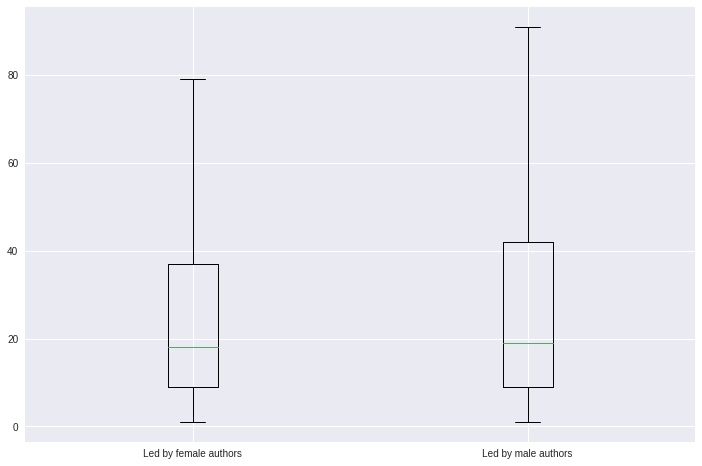

In [160]:
c_led_female_authors = c_led_female_authors[c_led_female_authors.notnull()]
c_led_male_authors = c_led_male_authors[c_led_male_authors.notnull()]
data_to_plot = [c_led_female_authors, c_led_male_authors]
# Create a figure instance
fig = plt.figure(1, figsize=(12, 8))
# Create an axes instance
ax = fig.add_subplot(111)
ax.set_xticklabels(['Led by female authors', 'Led by male authors'])
# Create the boxplot
bp = ax.boxplot(data_to_plot, showfliers=False)

#### Are the different statistically significant?

In [161]:
ttest,pval = ttest_ind(c_led_female_authors,c_led_male_authors)
if pval < 0.05:
    print("The difference is statistically significant, p-value:", pval)
else:
    print("The difference is not statistically significant, p-value:",round(pval,3))

The difference is statistically significant, p-value: 3.122439326734293e-11


### Citations of papers with female and male authors as last authors

In [162]:
citations_papers_female_author = papers[papers['gender_last_author']=='female']['citations']
citations_papers_male_author = papers[papers['gender_last_author']=='male']['citations']

In [163]:
citations_papers_female_author.describe()

count    9626.000000
mean       38.502701
std       112.696648
min         1.000000
25%         8.000000
50%        18.000000
75%        36.000000
max      5151.000000
Name: citations, dtype: float64

In [164]:
citations_papers_male_author.describe()

count    35149.000000
mean        50.637856
std        244.538457
min          1.000000
25%          9.000000
50%         19.000000
75%         41.000000
max      17237.000000
Name: citations, dtype: float64

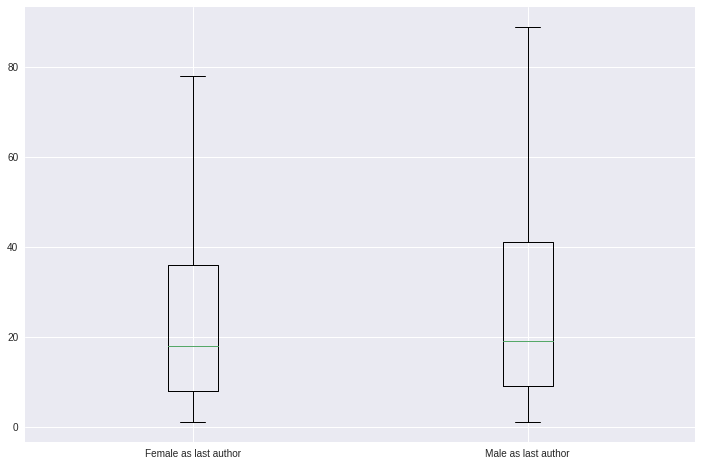

In [165]:
citations_papers_female_author = citations_papers_female_author[citations_papers_female_author.notnull()]
citations_papers_male_author = citations_papers_male_author[citations_papers_male_author.notnull()]
data_to_plot = [citations_papers_female_author, citations_papers_male_author]
# Create a figure instance
fig = plt.figure(1, figsize=(12, 8))
# Create an axes instance
ax = fig.add_subplot(111)
ax.set_xticklabels(['Female as last author', 'Male as last author'])
# Create the boxplot
bp = ax.boxplot(data_to_plot, showfliers=False)

#### Are the different statistically significant?

In [166]:
ttest,pval = ttest_ind(citations_papers_female_author, citations_papers_male_author)
if pval < 0.05:
    print("The difference is statistically significant, p-value:",pval)
else:
    print("The difference is not statistically significant, p-value:",round(pval,3))

The difference is statistically significant, p-value: 2.2183749497053467e-06


### Correlation between citations and gender distribution

In [167]:
papers_gender_dist['gender_ratio'] = np.where(papers_gender_dist['male'] > 0, 
                                              papers_gender_dist['female']/papers_gender_dist['male'], 
                                              50)

In [168]:
papers_gender_dist.head()

author_gender,female,male,most_female,most_male,equal_gender,only_male,only_female,gender_ratio
id,,,,,,,,
2-s2.0-13244249624,1.0,0.0,1,0,0,0,1,50.000000
2-s2.0-13244251063,1.0,9.0,0,1,0,0,0,0.111111
2-s2.0-13244251064,8.0,1.0,1,0,0,0,0,8.000000
2-s2.0-13244252316,0.0,1.0,0,1,0,1,0,0.000000
2-s2.0-13244255410,6.0,1.0,1,0,0,0,0,6.000000


In [175]:
papers_gdr = pd.DataFrame({'id': papers_gender_dist.index.values,
                           'female': papers_gender_dist['female'],
                           'male': papers_gender_dist['male'],
                           'gender_ratio':papers_gender_dist['gender_ratio']},
                          index=papers_gender_dist.index.values)

In [176]:
papers_gdr.head()

,id,female,male,gender_ratio
2-s2.0-13244249624,2-s2.0-13244249624,1.0,0.0,50.000000
2-s2.0-13244251063,2-s2.0-13244251063,1.0,9.0,0.111111
2-s2.0-13244251064,2-s2.0-13244251064,8.0,1.0,8.000000
2-s2.0-13244252316,2-s2.0-13244252316,0.0,1.0,0.000000
2-s2.0-13244255410,2-s2.0-13244255410,6.0,1.0,6.000000


In [177]:
papers_cgd = papers[['id','citations']].merge(papers_gdr, left_on='id', right_on='id')

In [178]:
papers_cgd.head()

,id,citations,female,male,gender_ratio
0,2-s2.0-85039860463,2.0,1.0,1.0,1.0
1,2-s2.0-85039845147,11.0,0.0,2.0,0.0
2,2-s2.0-85039843898,5.0,0.0,1.0,0.0
3,2-s2.0-85039761019,15.0,0.0,1.0,0.0
4,2-s2.0-85039757640,7.0,0.0,3.0,0.0


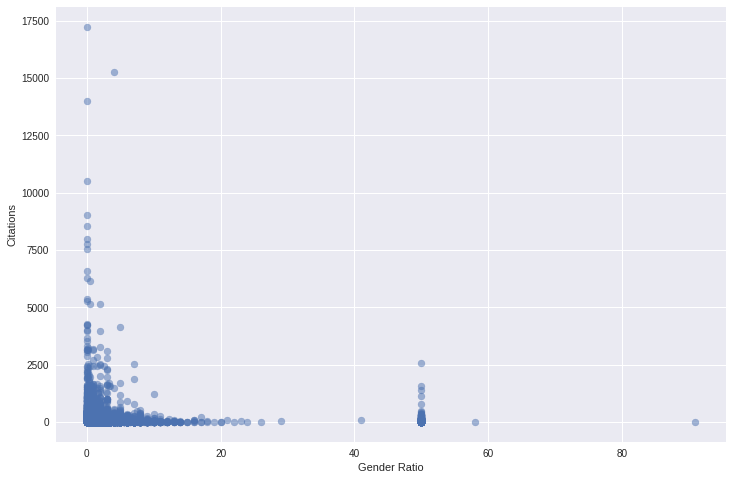

In [179]:
fig = plt.figure(1, figsize=(12, 8))
plt.scatter(papers_cgd['gender_ratio'], papers_cgd['citations'], alpha=0.5)
plt.ylabel('Citations')
plt.xlabel('Gender Ratio')
plt.show()

In [185]:
nans = np.logical_or(~papers_cgd['gender_ratio'].notnull(), ~papers_cgd['citations'].notnull())
corr, _ = pearsonr(papers_cgd[~nans]['gender_ratio'], papers_cgd[~nans]['citations'])
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: -0.014


## Content by gender

### Length of paper titles and gender

In [190]:
def length_titles(gender_group):
    lengths = papers[papers['id'].isin(papers_gender_dist[papers_gender_dist[gender_group]==1].index.values)]\
                    ['title'].map(lambda x: len(x))
    return lengths

#### Length of title in papers with `most female` authors vs `most male` authors

In [191]:
title_mostly_female_authors = length_titles('most_female')
title_mostly_male_authors = length_titles('most_male')

In [192]:
title_mostly_female_authors.describe()

count    13256.000000
mean        98.359837
std         32.539183
min          7.000000
25%         75.000000
50%         95.000000
75%        118.000000
max        308.000000
Name: title, dtype: float64

In [193]:
title_mostly_male_authors.describe()

count    26926.000000
mean        94.109560
std         31.261469
min          7.000000
25%         72.000000
50%         91.000000
75%        113.000000
max        273.000000
Name: title, dtype: float64

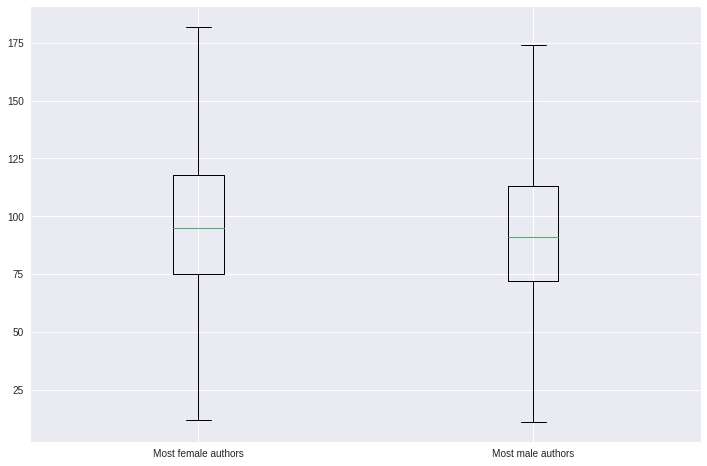

In [194]:
data_to_plot = [title_mostly_female_authors, title_mostly_male_authors]
# Create a figure instance
fig = plt.figure(1, figsize=(12, 8))
# Create an axes instance
ax = fig.add_subplot(111)
ax.set_xticklabels(['Most female authors', 'Most male authors'])
# Create the boxplot
bp = ax.boxplot(data_to_plot, showfliers=False)

##### Are the different statistically significant?

In [195]:
ttest,pval = ttest_ind(title_mostly_female_authors,title_mostly_male_authors)
if pval < 0.05:
    print("The difference is statistically significant, p-value:", pval)
else:
    print("The difference is not statistically significant, p-value:",round(pval,3))

The difference is statistically significant, p-value: 1.4683172644031425e-36


#### Length of title in papers with `only female` authors vs `only male` authors

In [196]:
title_only_female_authors = length_titles('only_female')
title_only_male_authors = length_titles('only_male')

In [197]:
title_only_female_authors.describe()

count    1775.000000
mean       97.362254
std        31.293768
min        18.000000
25%        75.000000
50%        94.000000
75%       116.000000
max       233.000000
Name: title, dtype: float64

In [198]:
title_only_male_authors.describe()

count    15583.000000
mean        91.084900
std         30.233949
min         11.000000
25%         69.000000
50%         88.000000
75%        109.000000
max        259.000000
Name: title, dtype: float64

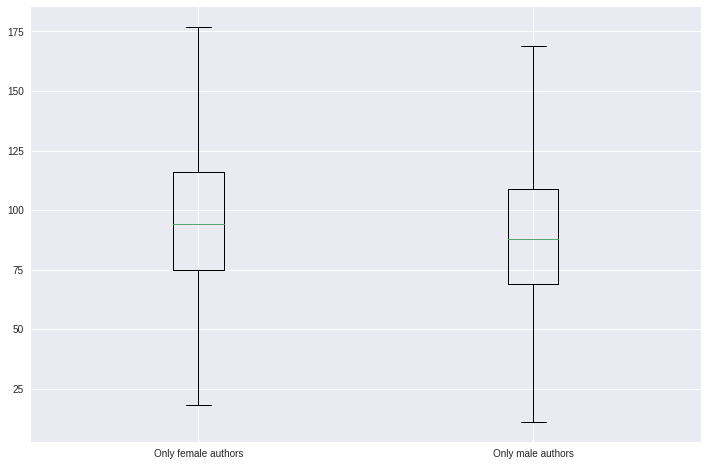

In [199]:
data_to_plot = [title_only_female_authors, title_only_male_authors]
# Create a figure instance
fig = plt.figure(1, figsize=(12, 8))
# Create an axes instance
ax = fig.add_subplot(111)
ax.set_xticklabels(['Only female authors', 'Only male authors'])
# Create the boxplot
bp = ax.boxplot(data_to_plot, showfliers=False)

##### Are the different statistically significant?

In [200]:
ttest,pval = ttest_ind(title_only_female_authors,title_only_male_authors)
if pval < 0.05:
    print("The difference is statistically significant, p-value:", pval)
else:
    print("The difference is not statistically significant, p-value:",round(pval,3))

The difference is statistically significant, p-value: 1.5857429459393237e-16


#### Length of title in papers with `lead by a female` author vs` lead by a male` author

In [201]:
title_lengths_f = papers[papers['title'].isin(papers_led_female_df.index.values)]['title'].map(lambda x: len(x))
title_lengths_m = papers[papers['title'].isin(papers_led_male_df.index.values)]['title'].map(lambda x: len(x))

In [202]:
title_lengths_f.describe()

count    11865.000000
mean        99.231606
std         32.521130
min          7.000000
25%         76.000000
50%         96.000000
75%        119.000000
max        308.000000
Name: title, dtype: float64

In [203]:
title_lengths_m.describe()

count    26146.000000
mean        93.438346
std         31.411178
min          7.000000
25%         71.000000
50%         91.000000
75%        113.000000
max        276.000000
Name: title, dtype: float64

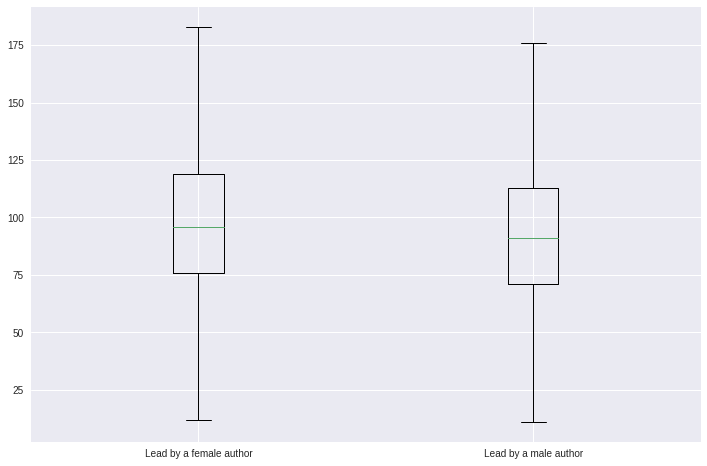

In [204]:
data_to_plot = [title_lengths_f, title_lengths_m]
# Create a figure instance
fig = plt.figure(1, figsize=(12, 8))
# Create an axes instance
ax = fig.add_subplot(111)
ax.set_xticklabels(['Lead by a female author', 'Lead by a male author'])
# Create the boxplot
bp = ax.boxplot(data_to_plot, showfliers=False)

##### Are the different statistically significant?

In [206]:
ttest,pval = ttest_ind(title_lengths_f,title_lengths_m)
if pval < 0.05:
    print("The difference is statistically significant, p-value:", pval)
else:
    print("The difference is not statistically significant, p-value:",round(pval,3))

The difference is statistically significant, p-value: 8.611769229083039e-61


#### Length of title in papers with a `female as last author` vs with a `male as last author`

In [207]:
title_lengths_lf = papers[papers['gender_last_author']=='female']['title'].map(lambda x: len(x))
title_lengths_lm = papers[papers['gender_last_author']=='male']['title'].map(lambda x: len(x))

In [208]:
title_lengths_lf.describe()

count    9781.000000
mean       98.569983
std        32.047251
min        17.000000
25%        76.000000
50%        95.000000
75%       118.000000
max       276.000000
Name: title, dtype: float64

In [209]:
title_lengths_lm.describe()

count    35669.000000
mean        95.044212
std         31.678200
min          7.000000
25%         73.000000
50%         92.000000
75%        114.000000
max        308.000000
Name: title, dtype: float64

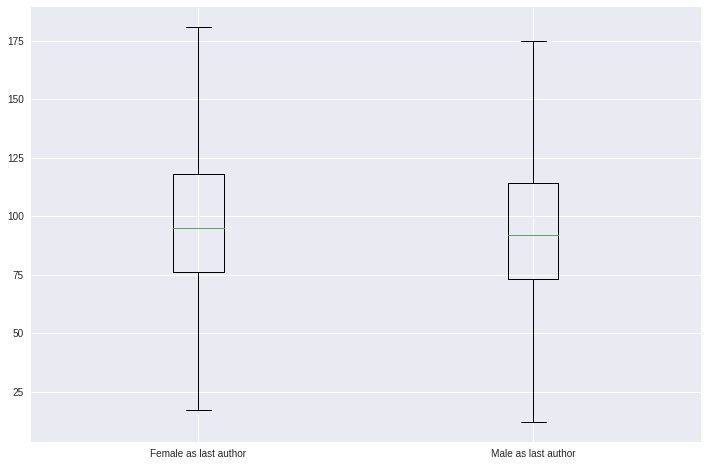

In [210]:
data_to_plot = [title_lengths_lf, title_lengths_lm]
# Create a figure instance
fig = plt.figure(1, figsize=(12, 8))
# Create an axes instance
ax = fig.add_subplot(111)
ax.set_xticklabels(['Female as last author', 'Male as last author'])
# Create the boxplot
bp = ax.boxplot(data_to_plot, showfliers=False)

##### Are the different statistically significant?

In [211]:
ttest,pval = ttest_ind(title_lengths_lf,title_lengths_lm)
if pval < 0.05:
    print("The difference is statistically significant, p-value:", pval)
else:
    print("The difference is not statistically significant, p-value:",round(pval,3))

The difference is statistically significant, p-value: 2.4362939965351828e-22


### Word frequency of paper titles and abstract by gender

In [212]:
from wordcloud import WordCloud, STOPWORDS
import random

In [247]:
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["background", "results", "conclusions"])
stopwords.update(["using", "based", "analysis", "univesity", "et", "al", "press", "ltd", "central", 
                  "author", "published", "oxford", "licensee"])

In [214]:
# Color functions
def blue_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(236, {}%, {}%)".format(random.randint(40, 100), random.randint(10, 60))
def pink_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(300, {}%, {}%)".format(random.randint(40, 100), random.randint(10, 60))

#### Word frequency in titles and abstracts of papers with `most male` authors vs with `most female` authors

In [233]:
content_mf = papers[papers['id'].isin(papers_gender_dist[papers_gender_dist['most_female']==1].index.values)]\
                  [['title', 'abstract']]
content_mm = papers[papers['id'].isin(papers_gender_dist[papers_gender_dist['most_male']==1].index.values)]\
                  [['title', 'abstract']]

In [234]:
# concatenate titles and abstract
all_titles_mf = " ".join(title for title in content_mf.title)
all_abstract_mf = " ".join(abstract for abstract in content_mf.abstract)
all_content_mf = all_titles_mf + ' ' + all_abstract_mf
all_titles_mm = " ".join(title for title in content_mm.title)
all_abstract_mm = " ".join(abstract for abstract in content_mm.abstract)
all_content_mm = all_titles_mm + ' ' + all_abstract_mm

In [248]:
# generate a word cloud image
wordcloud_mf = WordCloud(stopwords=stopwords, background_color="white", width=1024, height=768).\
                    generate(all_content_mf)
wordcloud_mm = WordCloud(stopwords=stopwords, background_color="white", width=1024, height=768).\
                    generate(all_content_mm)

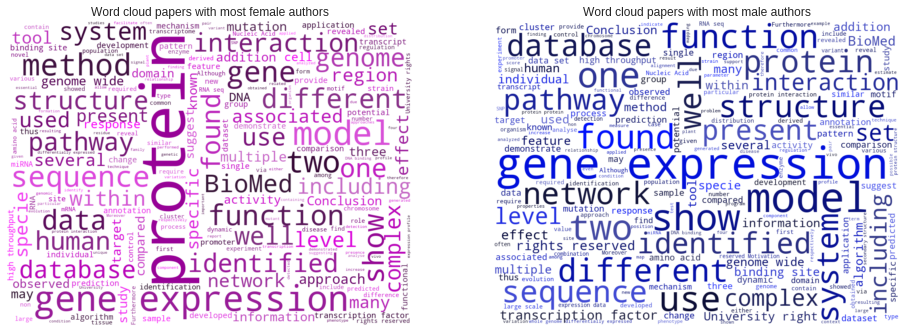

In [249]:
fig = plt.figure(1, figsize=(16, 12))
# prepare word cloud
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_mf.recolor(color_func=pink_color_func, random_state=3), interpolation='bilinear')
plt.axis("off")
plt.title('Word cloud papers with most female authors')
# prepare word cloud
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_mm.recolor(color_func=blue_color_func, random_state=3), interpolation='bilinear')
plt.axis("off")
plt.title('Word cloud papers with most male authors')
# show word clouds
plt.show()

#### Word frequency in titles of papers with `only female` authors vs `only male` authors

In [250]:
content_of = papers[papers['id'].isin(papers_gender_dist[papers_gender_dist['only_female']==1].index.values)]\
                  [['title', 'abstract']]
content_om = papers[papers['id'].isin(papers_gender_dist[papers_gender_dist['only_male']==1].index.values)]\
                  [['title', 'abstract']]

In [251]:
# concatenate titles
all_titles_of = " ".join(title for title in content_of.title)
all_abstract_of = " ".join(abstract for abstract in content_of.abstract)
all_content_of = all_titles_of + ' ' + all_abstract_of
all_titles_om = " ".join(title for title in content_om.title)
all_abstract_om = " ".join(abstract for abstract in content_om.abstract)
all_content_om = all_titles_om + ' ' + all_abstract_om

In [252]:
# generate a word cloud image
wordcloud_of = WordCloud(stopwords=stopwords, background_color="white", width=1024, height=768).\
                    generate(all_content_of)
wordcloud_om = WordCloud(stopwords=stopwords, background_color="white", width=1024, height=768).\
                    generate(all_content_om)

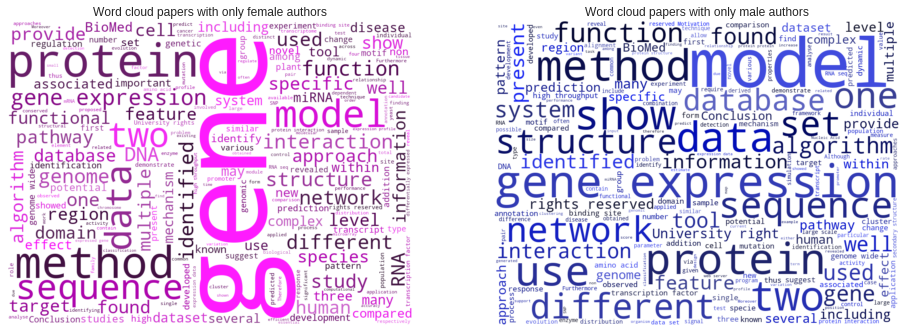

In [253]:
fig = plt.figure(1, figsize=(16, 12))
# prepare word cloud
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_of.recolor(color_func=pink_color_func, random_state=3), interpolation='bilinear')
plt.axis("off")
plt.title('Word cloud papers with only female authors')
# prepare word cloud
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_om.recolor(color_func=blue_color_func, random_state=3), interpolation='bilinear')
plt.axis("off")
plt.title('Word cloud papers with only male authors')
# show word clouds
plt.show()

#### Word frequency in titles of papers `lead by female` authors vs `lead by male` authors

In [260]:
content_lef = papers[papers['title'].isin(papers_led_female_df.index.values)][['title', 'abstract']]
content_lem = papers[papers['title'].isin(papers_led_male_df.index.values)][['title', 'abstract']]

In [261]:
# concatenate titles
all_titles_lef = " ".join(title for title in content_lef.title)
all_abstracts_lef = " ".join(abstract for abstract in content_lef.abstract)
all_content_lef = all_titles_lef + ' ' + all_abstracts_lef
all_titles_lem = " ".join(title for title in content_lem.title)
all_abstracts_lem = " ".join(abstract for abstract in content_lem.abstract)
all_content_lem = all_titles_lem + ' ' + all_abstracts_lem

In [262]:
# generate a word cloud image
wordcloud_lef = WordCloud(stopwords=stopwords, background_color="white", width=1024, height=768).\
                    generate(all_content_lef)
wordcloud_lem = WordCloud(stopwords=stopwords, background_color="white", width=1024, height=768).\
                    generate(all_content_lem)

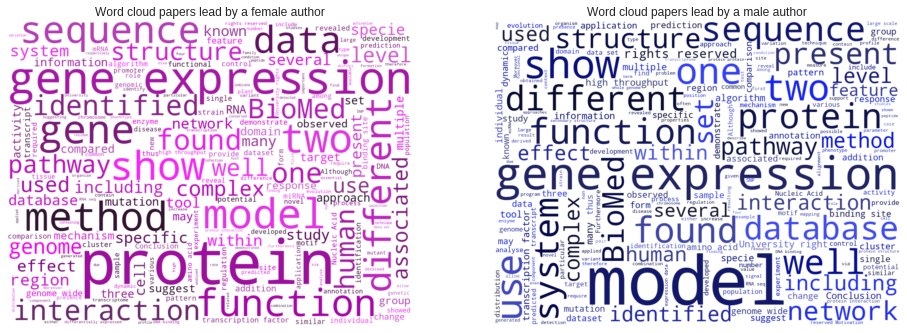

In [263]:
fig = plt.figure(1, figsize=(16, 12))
# prepare word cloud
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_lef.recolor(color_func=pink_color_func, random_state=3), interpolation='bilinear')
plt.axis("off")
plt.title('Word cloud papers lead by a female author')
# prepare word cloud
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_lem.recolor(color_func=blue_color_func, random_state=3), interpolation='bilinear')
plt.axis("off")
plt.title('Word cloud papers lead by a male author')
# show word clouds
plt.show()

#### Word frequency in titles of papers with a `female as last author` vs with a `male as last author`

In [265]:
content_laf = papers[papers['gender_last_author']=='female'][['title', 'abstract']]
content_lam = papers[papers['gender_last_author']=='male'][['title', 'abstract']]

In [266]:
# concatenate titles
all_titles_laf = " ".join(title for title in content_laf.title)
all_abstracts_laf = " ".join(abstract for abstract in content_laf.abstract)
all_content_laf = all_titles_laf + ' ' + all_abstracts_laf
all_titles_lam = " ".join(title for title in content_lam.title)
all_abstracts_lam = " ".join(abstract for abstract in content_lam.abstract)
all_content_lam = all_titles_lam + ' ' + all_abstracts_lam

In [267]:
# generate a word cloud image
wordcloud_laf = WordCloud(stopwords=stopwords, background_color="white", width=1024, height=768).\
                    generate(all_content_laf)
wordcloud_lam = WordCloud(stopwords=stopwords, background_color="white", width=1024, height=768).\
                    generate(all_content_lam)

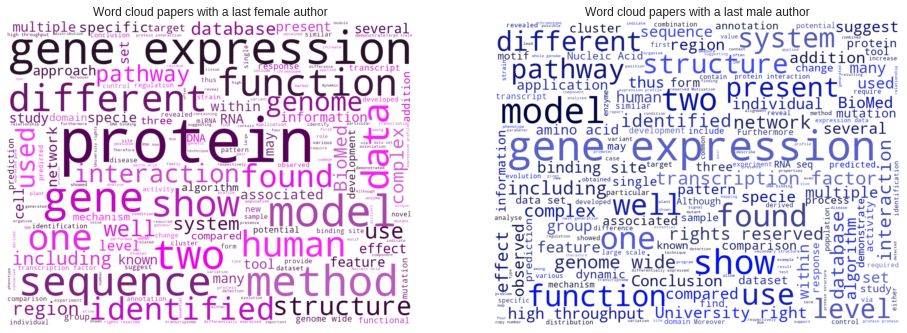

In [268]:
fig = plt.figure(1, figsize=(16, 12))
# prepare word cloud
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_laf.recolor(color_func=pink_color_func, random_state=3), interpolation='bilinear')
plt.axis("off")
plt.title('Word cloud papers with a last female author')
# prepare word cloud
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_lam.recolor(color_func=blue_color_func, random_state=3), interpolation='bilinear')
plt.axis("off")
plt.title('Word cloud papers with a last male author')
# show word clouds
plt.show()

### Sentiment analysis of words used in paper titles and gender

In [269]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [270]:
def analyze_sentiment(title):
    score = analyzer.polarity_scores(title)
    if score['compound'] >= 0.05:
        return 'positive'
    elif 0.05 > score['compound'] >= -0.05:
        return 'neutral'
    else:
        return 'negative'

In [271]:
def analyze_sentiment_score(title):
    score = analyzer.polarity_scores(title)
    return score['compound']

In [273]:
# Merge both title and abstract to ease the analysis
papers['title_abstract'] = papers['title'] + ' ' + papers['abstract']

#### Sentiment analysis of titles of papers with `most female` authors vs papers with `most male` authors

In [278]:
# compute sentiment analysis of titles
sa_title_mf = papers[papers['id'].isin(papers_gender_dist[papers_gender_dist['most_female']==1].index.values)]\
                                ['title_abstract'].map(analyze_sentiment)
sa_title_mm = papers[papers['id'].isin(papers_gender_dist[papers_gender_dist['most_male']==1].index.values)]\
                                ['title_abstract'].map(analyze_sentiment)

In [279]:
dist_f = sa_title_mf.value_counts()/len(sa_title_mf)
dist_m = sa_title_mm.value_counts()/len(sa_title_mm)

In [280]:
dist_f

positive    0.775951
negative    0.199909
neutral     0.024140
Name: title_abstract, dtype: float64

In [281]:
dist_m

positive    0.810072
negative    0.166456
neutral     0.023472
Name: title_abstract, dtype: float64

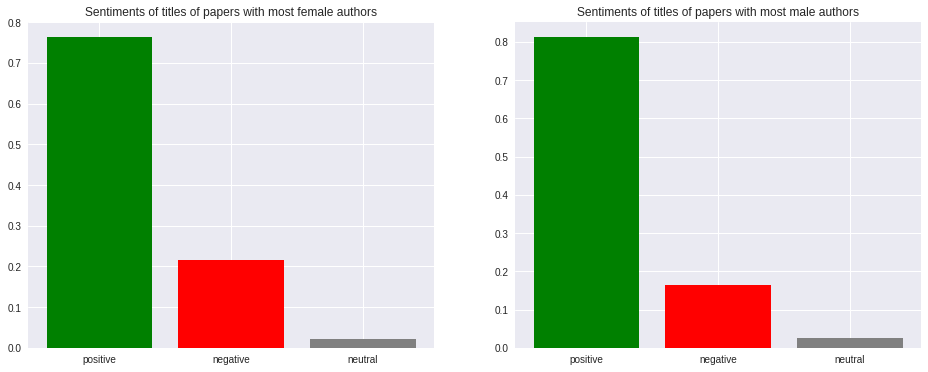

In [306]:
fig = plt.figure(1, figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.bar(dist_f.index, dist_f, color=['green', 'red', 'gray'])
plt.title('Sentiments of titles of papers with most female authors')
plt.subplot(1, 2, 2)
plt.bar(dist_m.index, dist_m, color=['green', 'red', 'gray'])
plt.title('Sentiments of titles of papers with most male authors')
plt.show()

##### Is statistically significant the different in score?

In [284]:
# compute sentiment analysis of titles
sas_title_mf = papers[papers['id'].isin(papers_gender_dist[papers_gender_dist['most_female']==1].index.values)]\
                                ['title_abstract'].map(analyze_sentiment_score)
sas_title_mm = papers[papers['id'].isin(papers_gender_dist[papers_gender_dist['most_male']==1].index.values)]\
                                ['title_abstract'].map(analyze_sentiment_score)

In [286]:
print('Mean SA scores of titles and abstracts of papers with only female authors: {0:1.3f}'.format(sas_title_mf.mean()))
print('Mean SA scores of titles and abstracts of papers with only male authors: {0:1.3f}'.format(sas_title_mm.mean()))

Mean SA scores of titles and abstracts of papers with only female authors: 0.464
Mean SA scores of titles and abstracts of papers with only male authors: 0.523


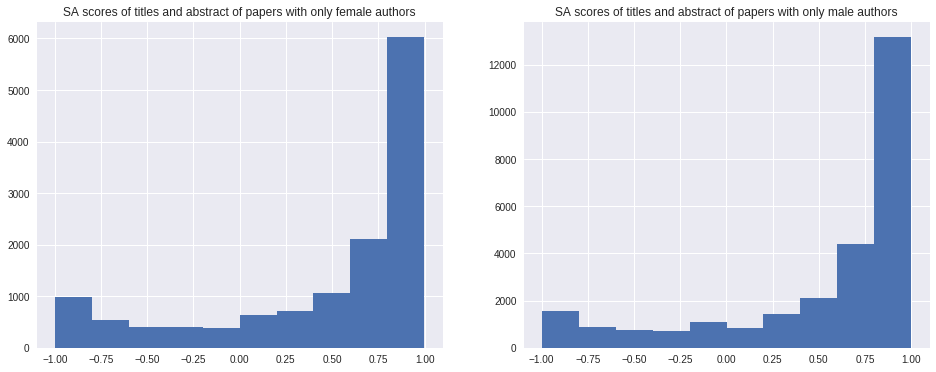

In [287]:
fig = plt.figure(1, figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.hist(sas_title_mf)
plt.title('SA scores of titles and abstract of papers with only female authors')
plt.subplot(1, 2, 2)
plt.hist(sas_title_mm)
plt.title('SA scores of titles and abstract of papers with only male authors')
plt.show()

In [288]:
stat, p = mannwhitneyu(sas_title_mf, sas_title_mm)
print('statistics= {0:1.1f}, p-value= {1:3.4f}'.format(stat, p))

statistics= 168572420.5, p-value= 0.0000


#### Sentiment analysis of titles of papers with `only female` authors vs papers with `only male` authors

In [289]:
# compute sentiment analysis of titles
sa_title_of = papers[papers['id'].isin(papers_gender_dist[papers_gender_dist['only_female']==1].index.values)]\
                                ['title_abstract'].map(analyze_sentiment)
sa_title_om = papers[papers['id'].isin(papers_gender_dist[papers_gender_dist['only_male']==1].index.values)]\
                                ['title_abstract'].map(analyze_sentiment)

In [290]:
dist_f = sa_title_of.value_counts()/len(sa_title_of)
dist_m = sa_title_om.value_counts()/len(sa_title_om)

In [291]:
dist_f

positive    0.794930
negative    0.175211
neutral     0.029859
Name: title_abstract, dtype: float64

In [292]:
dist_m

positive    0.836168
negative    0.139960
neutral     0.023872
Name: title_abstract, dtype: float64

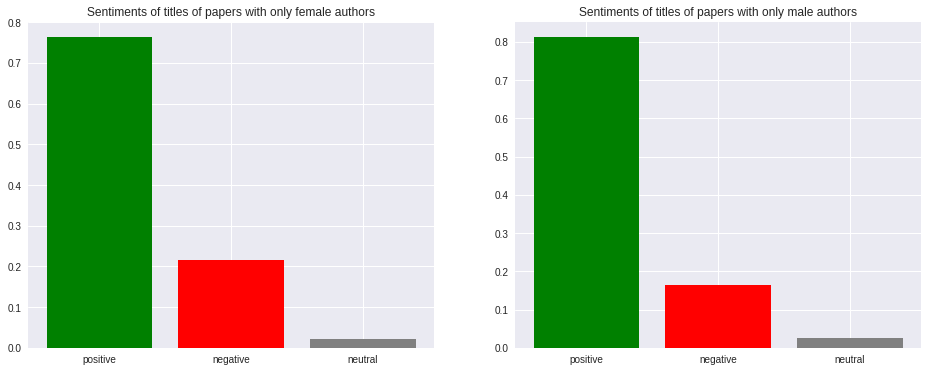

In [305]:
fig = plt.figure(1, figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.bar(dist_f.index, dist_f, color=['green', 'red', 'gray'])
plt.title('Sentiments of titles of papers with only female authors')
plt.subplot(1, 2, 2)
plt.bar(dist_m.index, dist_m, color=['green', 'red', 'gray'])
plt.title('Sentiments of titles of papers with only male authors')
plt.show()

##### Is statistically significant the different in score?

In [294]:
# compute sentiment analysis of titles
sas_title_of = papers[papers['id'].isin(papers_gender_dist[papers_gender_dist['only_female']==1].index.values)]\
                                ['title_abstract'].map(analyze_sentiment_score)
sas_title_om = papers[papers['id'].isin(papers_gender_dist[papers_gender_dist['only_male']==1].index.values)]\
                                ['title_abstract'].map(analyze_sentiment_score)

In [296]:
print('Mean SA scores of titles and abstracts of papers with only female authors: {0:1.3f}'.format(sas_title_of.mean()))
print('Mean SA scores of titles and abstracts of papers with only male authors: {0:1.3f}'.format(sas_title_om.mean()))

Mean SA scores of titles and abstracts of papers with only female authors: 0.506
Mean SA scores of titles and abstracts of papers with only male authors: 0.569


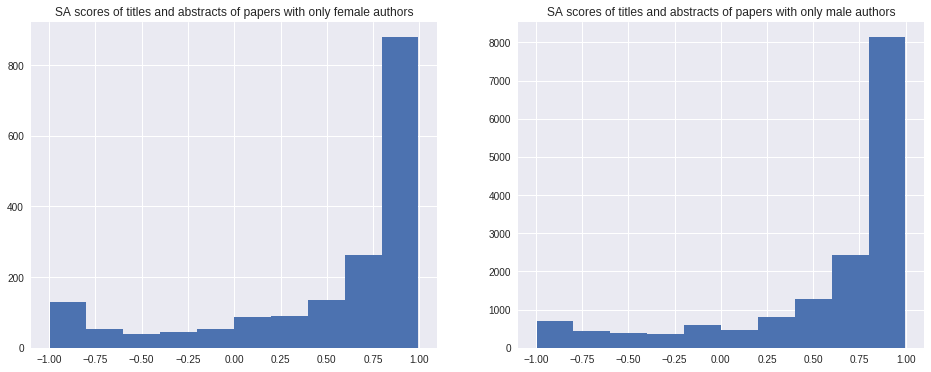

In [297]:
fig = plt.figure(1, figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.hist(sas_title_of)
plt.title('SA scores of titles and abstracts of papers with only female authors')
plt.subplot(1, 2, 2)
plt.hist(sas_title_om)
plt.title('SA scores of titles and abstracts of papers with only male authors')
plt.show()

In [298]:
stat, p = mannwhitneyu(sas_title_of, sas_title_om)
print('statistics= {0:1.1f}, p-value= {1:3.4f}'.format(stat, p))

statistics= 13158793.5, p-value= 0.0004


#### Sentiment analysis of titles of papers `lead by a female` author vs papers `lead by a male` author

In [299]:
# compute sentiment analysis of titles
sa_titles_lef = papers[papers['title'].isin(papers_led_female_df.index.values)]['title_abstract'].map(analyze_sentiment)
sa_titles_lem = papers[papers['title'].isin(papers_led_male_df.index.values)]['title_abstract'].map(analyze_sentiment)

In [300]:
dist_f = sa_titles_lef.value_counts()/len(sa_titles_lef)
dist_m = sa_titles_lem.value_counts()/len(sa_titles_lem)

In [301]:
dist_f

positive    0.763085
negative    0.215339
neutral     0.021576
Name: title_abstract, dtype: float64

In [302]:
dist_m

positive    0.811902
negative    0.163084
neutral     0.025013
Name: title_abstract, dtype: float64

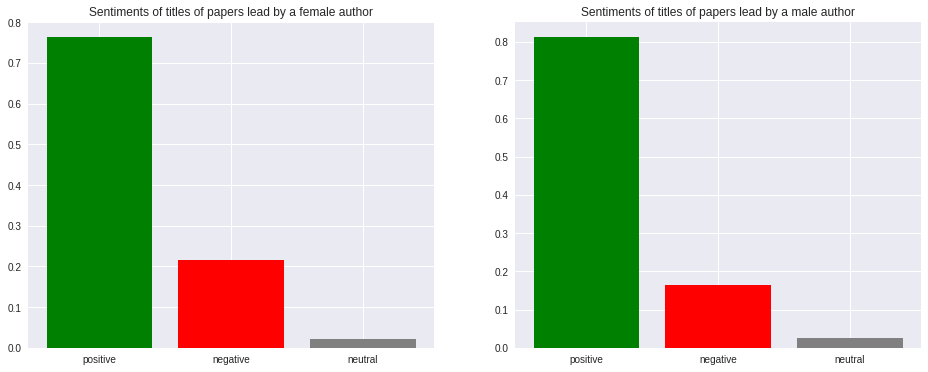

In [304]:
fig = plt.figure(1, figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.bar(dist_f.index, dist_f, color=['green', 'red', 'gray'])
plt.title('Sentiments of titles of papers lead by a female author')
plt.subplot(1, 2, 2)
plt.bar(dist_m.index, dist_m, color=['green', 'red', 'gray'])
plt.title('Sentiments of titles of papers lead by a male author')
plt.show()

##### Is statistically significant the different in score?

In [309]:
# compute sentiment analysis of titles
sas_title_lef = papers[papers['title'].isin(papers_led_female_df.index.values)]['title_abstract'].map(analyze_sentiment_score)
sas_title_lem = papers[papers['title'].isin(papers_led_male_df.index.values)]['title_abstract'].map(analyze_sentiment_score)

In [310]:
print('Mean SA scores of titles and abstracts of papers lead by a female author: {0:1.3f}'.format(sas_title_lef.mean()))
print('Mean SA scores of titles and abstracts of papers lead by a male author: {0:1.3f}'.format(sas_title_lem.mean()))

Mean SA scores of titles and abstracts of papers lead by a female author: 0.436
Mean SA scores of titles and abstracts of papers lead by a male author: 0.527


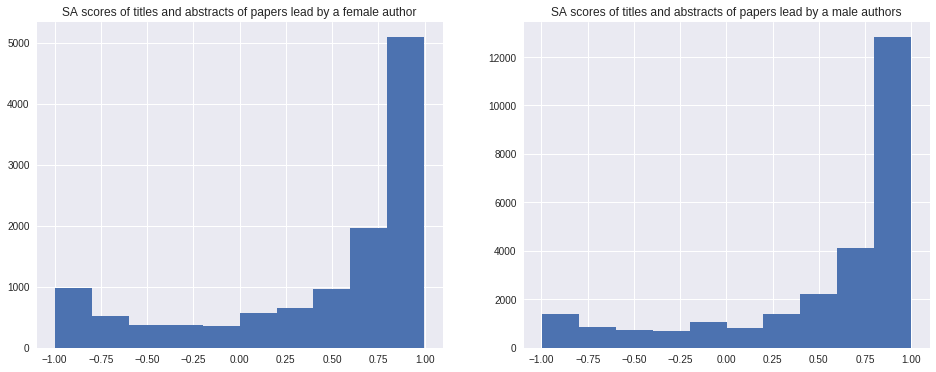

In [311]:
fig = plt.figure(1, figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.hist(sas_title_lef)
plt.title('SA scores of titles and abstracts of papers lead by a female author')
plt.subplot(1, 2, 2)
plt.hist(sas_title_lem)
plt.title('SA scores of titles and abstracts of papers lead by a male authors')
plt.show()

In [312]:
stat, p = mannwhitneyu(sas_title_lef, sas_title_lem)
print('statistics= {0:1.1f}, p-value= {1:3.4f}'.format(stat, p))

statistics= 141474943.0, p-value= 0.0000


#### Sentiment analysis of titles of papers that have a `female as last author` author vs papers that have a `male as last author`

In [313]:
# compute sentiment analysis of titles
sa_titles_lf = papers[papers['gender_last_author']=='female']['title_abstract'].map(analyze_sentiment)
sa_titles_lm = papers[papers['gender_last_author']=='male']['title_abstract'].map(analyze_sentiment)

In [314]:
dist_f = sa_titles_lf.value_counts()/len(sa_titles_lf)
dist_m = sa_titles_lm.value_counts()/len(sa_titles_lm)

In [315]:
dist_f

positive    0.780595
negative    0.194765
neutral     0.024640
Name: title_abstract, dtype: float64

In [316]:
dist_m

positive    0.801957
negative    0.174577
neutral     0.023466
Name: title_abstract, dtype: float64

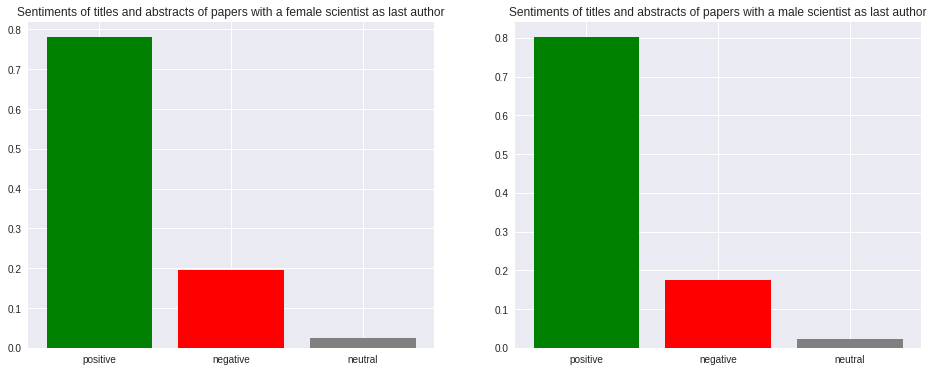

In [318]:
fig = plt.figure(1, figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.bar(dist_f.index, dist_f, color=['green', 'red', 'gray'])
plt.title('Sentiments of titles and abstracts of papers with a female scientist as last author')
plt.subplot(1, 2, 2)
plt.bar(dist_m.index, dist_m, color=['green', 'red', 'gray'])
plt.title('Sentiments of titles and abstracts of papers with a male scientist as last author')
plt.show()

##### Is statistically significant the different in score?

In [319]:
# compute sentiment analysis of titles
sas_titles_lf = papers[papers['gender_last_author']=='female']['title_abstract'].map(analyze_sentiment_score)
sas_titles_lm = papers[papers['gender_last_author']=='male']['title_abstract'].map(analyze_sentiment_score)

In [320]:
print('Mean SA scores of titles and abstracts of papers with a female scientist as last author: {0:1.3f}'.format(sas_titles_lf.mean()))
print('Mean SA scores of titles and abstracts of papers with a male scientist as last author: {0:1.3f}'.format(sas_titles_lm.mean()))

Mean SA scores of titles and abstracts of papers with a female scientist as last author: 0.472
Mean SA scores of titles and abstracts of papers with a male scientist as last author: 0.509


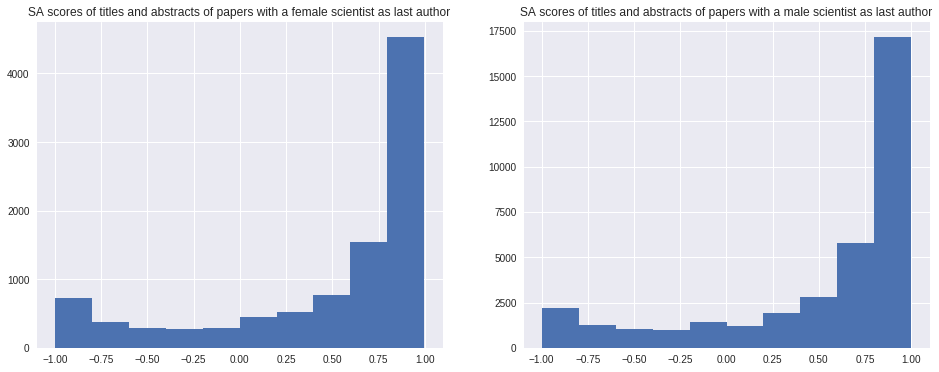

In [321]:
fig = plt.figure(1, figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.hist(sas_titles_lf)
plt.title('SA scores of titles and abstracts of papers with a female scientist as last author')
plt.subplot(1, 2, 2)
plt.hist(sas_titles_lm)
plt.title('SA scores of titles and abstracts of papers with a male scientist as last author')
plt.show()

In [322]:
stat, p = mannwhitneyu(sas_titles_lf, sas_titles_lm)
print('statistics= {0:1.1f}, p-value= {1:3.4f}'.format(stat, p))

statistics= 168846443.0, p-value= 0.0000


## Análisis a realizar para completar estudio:
1. Estudiar que tanto los autores más productivos (y citados) publican con gente del otro género
2. Distribución de género en papers más citados
3. Evolucion de genero (primer y último autor)
4. Distribución de temáticas por género
5. Evolución tématicas por año (general, hombres, mujeres)
6. Comparar revistas (por año, por género, por citas). 
7. Agrupar revistas (2 grupos, grupo 1=Nucleic, BMC Genomic, Bioinformatics, grupo 2=BMC Bioinformatics, Plos) y comparar
8. Evolución de sentimiento por año (o rango de años)
9. Afiliación por país, ciudad. Evolución en el tiempo